In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import pickle
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Load cleaned dataset
file_path = "dataset/cleaned_creditcard.csv"
df = pd.read_csv(file_path)

In [3]:
# Separate features and target
X = df.drop(columns=["Class"])
y = df["Class"]

# Handle class imbalance using upsampling
df_majority = df[df.Class == 0]
df_minority = df[df.Class == 1]

df_minority_upsampled = resample(df_minority, replace=True, 
                                 n_samples=len(df_majority), random_state=42)

df_balanced = pd.concat([df_majority, df_minority_upsampled])

X_balanced = df_balanced.drop(columns=["Class"])
y_balanced = df_balanced["Class"]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)


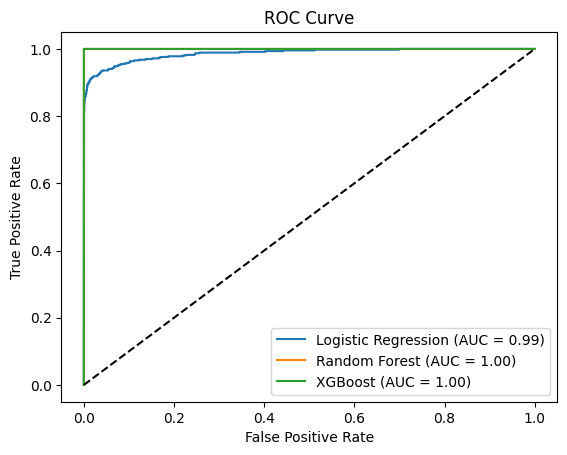

,Precision,Recall,F1-score,AUC-ROC
Logistic Regression,0.975744,0.918678,0.946352,0.986493
Random Forest,0.999930,1.000000,0.999965,1.000000
XGBoost,0.999912,1.000000,0.999956,1.000000


In [5]:
# Train models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss")
}

results = {}

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Save trained model
    with open(f"models/{name}_model.pkl", "wb") as f:
        pickle.dump(model, f)
    
    # Predict and evaluate
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    auc_roc = roc_auc_score(y_test, y_pred_prob)
    report = classification_report(y_test, y_pred, output_dict=True)

    results[name] = {
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1-score": report["1"]["f1-score"],
        "AUC-ROC": auc_roc
    }

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_roc:.2f})")


#transform XGBoost format
with open("models/XGBoost_model.pkl", "rb") as f:
    bst = pickle.load(f)
    
bst.save_model("models/XGBoost_model.json") 


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Convert results to DataFrame for easy comparison
results_df = pd.DataFrame(results).T
display(results_df)